# Imports

In [8]:
import os 
import warnings

warnings.filterwarnings("ignore")
os.chdir("/Users/erjo3868/repos/hypedsearch/hypedsearch")
print(f"cwd = {os.getcwd()}")

from concurrent.futures import ThreadPoolExecutor
from src.erik import (
    query_database, 
    get_query_to_select_rows_by_mass, 
    relative_ppm_tolerance_in_daltons, 
    generate_kmers
)
from src.erik_constants import (
    MOUSE_PROTEOME, FASTAS_DIR, GIT_REPO_DIR, PLOTS_DIR

)
from scripts.mass_vs_num_kmers_explaining_mass import sample_from_kmer_db
from typing import Any, List, Tuple, Dict
from src.erik_utils import (
    pickle_object,
    pickle_and_compress,
    decompress_and_unpickle,
    run_in_parallel
)
from src.erik_utils import (
    get_proteins_from_fasta
)
from src.plot_utils import (
    fig_setup,
    finalize,
    set_title_axes_labels,
)
import sqlite3
import time
import numpy as np
import pandas as pd
from dataclasses import dataclass
# db_path = "./dbs/kmer_db_fasta=Uniprot_mouse.fasta_max_k=50_charges=[1].db" # Fiji
KMERS_DB_PATH = "./dbs/Uniprot_mouse.fasta.uniq_kmers.max_k=50.db" # local


cwd = /Users/erjo3868/repos/hypedsearch/hypedsearch


# Ground truth

# Number of unique k-mers

In [12]:
# Constants
fasta_path = MOUSE_PROTEOME
max_kmer_len = 50

uniq_kmers = set()
proteins = list(get_proteins_from_fasta(fasta_path=fasta_path))

# t0 = time.time()
# with ThreadPoolExecutor() as executor:
#     results = list(executor.map(lambda protein: set(generate_kmers(peptide=protein.seq, max_k=max_kmer_len)), proteins))
# t1 = time.time()
# print(f"\tTook {round(t1-t0, 2)} seconds for {len(proteins)} proteins")

num_proteins = len(proteins)
t0 = time.time()
for p_num, protein in enumerate(proteins):
    if (p_num % 100 == 0):
        print(f"Protein {p_num+1} of {num_proteins}")
        t1 = time.time()
        print(f"\ttook {round(t1-t0, 2)} seconds")
        t0 = time.time()
    kmers = generate_kmers(peptide=protein.seq, max_k=max_kmer_len)
    uniq_kmers.update(kmers)

print(f"Number unique kmers of length 1 to {max_kmer_len} = {len(uniq_kmers)}")

Protein 1 of 21759
	took 0.0 seconds


KeyboardInterrupt: 

In [ ]:
print(f"Number unique kmers of length 1 to {max_kmer_len} = {len(uniq_kmers)}")

# Pickle object
# output_name = FASTAS_DIR / (MOUSE_PROTEOME.name + f".uniq_kmers.max_k={max_kmer_len}.pkl")
# t0 = time.time()
# pickle_object(obj=uniq_kmers, filename=output_name)
# t1 = time.time()
# print(f"Pickling took {round(t1-t0, 3)} seconds")

# # Save to database
# output_file = FASTAS_DIR / (MOUSE_PROTEOME.name + f".uniq_kmers.max_k={max_kmer_len}.db")
# conn = sqlite3.connect(output_file)
# cursor = conn.cursor()
# t0 = time.time()
# cursor.execute("CREATE TABLE IF NOT EXISTS uniq_kmers (kmer TEXT PRIMARY KEY)")
# cursor.executemany("INSERT OR IGNORE INTO  uniq_kmers(kmer) VALUES (?)", ((kmer,) for kmer in uniq_kmers))
# conn.commit()
# t1 = time.time()
# print(f"Creating DB took {round(t1-t0, 3)} seconds")
# conn.close()

# Pickle & compress object
output_name = FASTAS_DIR / (MOUSE_PROTEOME.name + f".uniq_kmers.max_k={max_kmer_len}.gz")
t0 = time.time()
pickle_and_compress(obj=uniq_kmers, filename=output_name)
t1 = time.time()
print(f"Pickling took {round(t1-t0, 3)} seconds")

Number unique kmers of length 1 to 50 = 480040136


In [ ]:
x = decompress_and_unpickle(filename=output_name)
len(x)

# Basic database information

In [19]:
# Tables in DB
query = """SELECT name
FROM sqlite_master
WHERE type = 'table';"""
t0 = time.time()
r = query_database(query=query, db_path=KMERS_DB_PATH)
t1 = time.time()
print(f"Tables = {r}")
print(f"\t query took {round(t1-t0, 3)} seconds")

# Indices in table
table = "kmers"
query = f"""
SELECT name
FROM sqlite_master
WHERE type = 'index' AND tbl_name = '{table}';
"""
t0 = time.time()
r = query_database(query=query, db_path=KMERS_DB_PATH)
t1 = time.time()
print(f"Indices in {table} = {r}")
print(f"\t query took {round(t1-t0, 3)} seconds")

# Table info
query = f"PRAGMA table_info({table});"
t0 = time.time()
r = query_database(query=query, db_path=KMERS_DB_PATH)
t1 = time.time()
print(f"{table} info:\n\t{r}")
print(f"\t query took {round(t1-t0, 3)} seconds")

Tables = [('kmers',)]
	 query took 0.001 seconds
Indices in kmers = [('sqlite_autoindex_kmers_1',), ('idx_mass',)]
	 query took 0.0 seconds
kmers info:
	[(0, 'sequence', 'TEXT', 0, None, 1), (1, 'mass', 'REAL', 0, None, 0)]
	 query took 0.0 seconds


In [ ]:
# Rows in table
# query = f"SELECT COUNT(mass) FROM {table}"
# t0 = time.time()
# r = query_database(query=query, db_path=db_path)
# t1 = time.time()
# print(f"Rows in {table} table = {r}")
# print(f"\t query took {round(t1-t0, 3)} seconds")

# Stats about table
query = f"SELECT COUNT(*), MAX(LENGTH(sequence)), MIN(mass), MAX(mass) FROM {table};"
t0 = time.time()
r = query_database(query=query, db_path=KMERS_DB_PATH)
kmer_count, max_kmer_len, min_kmer_mass, max_kmer_mass = r[0]
t1 = time.time()
print((
    f"Stats on {KMERS_DB_PATH}:\n"
    f"\t- num kmers = {kmer_count}\n"
    f"\t- min kmer mass = {min_kmer_mass}\n"
    f"\t- max kmer mass = {max_kmer_mass}\n"
    f"\t- max kmer length = {max_kmer_len}"
))
print(f"\t query took {round(t1-t0, 3)} seconds")


Stats on ./dbs/Uniprot_mouse.fasta.uniq_kmers.max_k=50.db:
	- num kmers = 480040136
	- min kmer mass = 57.021464
	- max kmer mass = 7109.124191000004
	- max kmer length = 50
	 query took 127.465 seconds


In [ ]:
# Get kmer masses
query = "SELECT mass FROM kmers"
t0 = time.time()
r = query_database(query=query, db_path=KMERS_DB_PATH)
t1 = time.time()
print(f"\t query took {round(t1-t0, 3)} seconds")
masses = [item[0] for item in r]


	 query took 99.152 seconds


# Rows explaining masses

## Sample masses from database

In [6]:
db_path = GIT_REPO_DIR / "./dbs/Uniprot_mouse.fasta.uniq_kmers.max_k=50.db"
num_samples = 1000000
num_iterations = 4
input_array = [num_samples] * num_iterations

fcn = lambda num_samples: sample_from_kmer_db(num_rows=num_samples, db_path=db_path)

t0 = time.time()
kmers = run_in_parallel(fcn_of_one_variable=fcn, input_array=input_array)
t1 = time.time()
duration = round(t1-t0, 2)
print(f"Sampling took {duration} secs = {round(duration/60, 2)} mins")
masses = [kmer.mass for kmer in kmers]

# Pickle masses
save_path = PLOTS_DIR / f"{db_path.name}.num_masses={len(masses)}.pkl"
t0 = time.time()
pickle_and_compress(obj=masses, file_path=save_path)
t1 = time.time()
duration = round(t1-t0, 2)
print(f"Pickling took {duration} secs = {round(duration/60, 2)} mins")

get_random_rows with num_rows=1000000 took 405.33 seconds
get_random_rows with num_rows=1000000 took 407.68 seconds
get_random_rows with num_rows=1000000 took 409.16 seconds
get_random_rows with num_rows=1000000 took 409.18 seconds
Sampling took 413.26 secs = 6.89 mins


## Use masses from db itself

In [ ]:
from scripts.mass_vs_num_kmers_explaining_mass import plot_explanatory_kmers, sample_in_parallel
from src.erik_constants import GIT_REPO_DIR, PLOTS_DIR

# For reals
num_samples = 10000000
# ppm_tols = [3, 5, 10]
ppm_tols = [5]
num_folds = 4
db_path = GIT_REPO_DIR / "./dbs/Uniprot_mouse.fasta.uniq_kmers.max_k=50.db"
# db_path = GIT_REPO_DIR / "./dbs/test.fasta.db"

for ppm_tol in ppm_tols:
    t0 = time.time()
    # Sample and get explanatory kmers
    explanatory_kmers = sample_in_parallel(
        num_samples=num_samples,
        num_folds=num_folds,
        ppm_tol=ppm_tol,
        kmer_db_path=db_path,
    )
    save_path = PLOTS_DIR / f"{db_path.name}.ppm_tol={ppm_tol}.pkl"
    pickle_and_compress(obj=explanatory_kmers, file_path=save_path)

    save_path = PLOTS_DIR / f"{db_path.name}.ppm_tol={ppm_tol}.png"
    plot_explanatory_kmers(
        explanatory_kmers=explanatory_kmers, save_path=save_path, ppm_tol=ppm_tol
    )
    t1 = time.time()
    print(f"PPM tol={ppm_tol} took {round(t1-t0, 2)} seconds")

get_random_rows with num_rows=10000000 took 713.9 seconds
get_random_rows with num_rows=10000000 took 740.52 seconds
get_random_rows with num_rows=10000000 took 755.55 seconds
get_random_rows with num_rows=10000000 took 774.35 seconds


In [8]:

@dataclass
class Kmer:
    seq: str
    mass: float

kmers = [Kmer(seq=kmer[0], mass=kmer[1]) for kmer in kmers]

In [16]:
from scripts.mass_vs_num_kmers_explaining_mass import get_explanatory_kmers_for_many_masses, get_explanatory_kmers

ppm_tol = 10
masses = [kmer.mass for kmer in kmers]

fcn = lambda mass: get_explanatory_kmers(
    mass=mass, ppm_tol=ppm_tol, db_path=KMERS_DB_PATH
)
fcn = lambda masses: get_explanatory_kmers_for_many_masses(
    kmers=kmers, ppm_tol=10, db_path=KMERS_DB_PATH
)

# This query took:
# - ~390 seconds=6.5 minutes for 1 million masses
t0 = time.time()
explanatory_kmers = list(run_in_parallel(fcn_of_one_variable=fcn, input_array=masses))
t1 = time.time()
print(f"Query took {round(t1-t0, 2)} seconds")


Query took 388.72 seconds


In [18]:
explanatory_kmers

[2002,
 9067,
 21449,
 5561,
 19612,
 1143,
 2427,
 12995,
 5236,
 10505,
 2963,
 10955,
 16382,
 15293,
 21909,
 8013,
 19466,
 14731,
 10273,
 451,
 15159,
 10639,
 14045,
 9094,
 15183,
 19031,
 10143,
 10997,
 15589,
 7125,
 19869,
 435,
 5984,
 14037,
 23015,
 13390,
 14930,
 13723,
 1648,
 7714,
 11543,
 21319,
 8467,
 23950,
 22972,
 4650,
 8671,
 7721,
 19016,
 9113,
 15152,
 1746,
 18923,
 10784,
 2378,
 3787,
 11550,
 6085,
 18028,
 17753,
 6589,
 19822,
 8717,
 18761,
 12370,
 14620,
 15969,
 18056,
 16592,
 20028,
 19501,
 18703,
 3092,
 18149,
 10722,
 13611,
 7607,
 12329,
 13630,
 7532,
 19663,
 21787,
 15803,
 17371,
 23991,
 10599,
 7216,
 10549,
 18599,
 19586,
 22453,
 22542,
 9120,
 22397,
 19308,
 15833,
 21241,
 13821,
 10352,
 7647,
 17250,
 9901,
 4250,
 17693,
 15282,
 13026,
 6500,
 18974,
 15916,
 7853,
 14788,
 3693,
 2492,
 22293,
 7042,
 13494,
 3025,
 6040,
 17361,
 6180,
 19867,
 5212,
 7632,
 12968,
 23833,
 19700,
 3669,
 22870,
 10421,
 10670,
 11464,

In [ ]:
fcn = lambda kmers: get_explanatory_kmers_for_many_masses(
    kmers=kmers, ppm_tol=10, db_path=KMERS_DB_PATH
)

t0 = time.time()
explanatory_kmers = list(run_in_parallel(fcn_of_one_variable=fcn, input_array=result))
t1 = time.time()

In [2]:
data = []

@dataclass
class QueryResult:
    result: Any 
    duration: float

def get_random_rows(num_rows):
    query = f"""
    SELECT *
    FROM kmers
    ORDER BY RANDOM()
    LIMIT {num_rows};
    """
    t0 = time.time()
    result = query_database(query=query, db_path=KMERS_DB_PATH)
    t1 = time.time()
    return QueryResult(result=result, duration=t1-t0)


t0 = time.time()
num_rows = [100000, 100000, 100000, 100000]
result = list(run_in_parallel(fcn_of_one_variable=get_random_rows, input_array=num_rows))
t1 = time.time()
print(f"Query took {round(t1-t0, 2)} seconds")


Query took 240.37 seconds


In [5]:
result[0].result[:10]

[('STVQIVNNGKILKLF', 1654.9770269999997),
 ('GPDMDELSGDSNFTMED', 1840.67676),
 ('TVRFFIL', 876.52216),
 ('PSMLLESEDELLVDEEEAAALLESGSSVGDETDLANL', 3871.7932350000005),
 ('PIDLMKIQQKLKMEEYD', 2103.074427),
 ('AILSFLHIWAV', 1250.717565),
 ('GKCMSQTNSTFTFTTCRILHPSD', 2556.1559519999996),
 ('SGKPATTSAQLPLEPPLWRLQRHEEGSETAVEGGQ', 3737.876154),
 ('PVNIKAARQDLLAVPPDLTSAAAMYRGPVYALHDVS', 3801.0035850000004),
 ('GFSEPYLQFQDPSKHSRKVNPTTKYLVISLSVLS', 3847.0308430000005)]

In [ ]:
result = [r.result for r in result]

In [34]:

def get_explanatory_kmers(mass: float, ppm_tol: int, db_path: str):
    da_tol = relative_ppm_tolerance_in_daltons(ppm=ppm_tol, ref_mass=mass)
    query = get_query_to_select_rows_by_mass(
        mass=mass, 
        mass_tol=da_tol, 
        # query_type="both"
    )
    # print(f"mass={mass}\nda_tol={da_tol}\nquery:\n{query}")
    return query_database(query=query, db_path=db_path)[0][0]

@dataclass
class ExplanatoryKmers:
    mass: float
    num_explanatory_kmers: int


def get_explanatory_kmers_for_many_masses(kmers: List[Tuple[str, float]], ppm_tol: int, db_path: str):
    data = []
    for kmer in kmers:
        mass = kmer[1]
        data.append(ExplanatoryKmers(
            mass=mass,
            num_explanatory_kmers=get_explanatory_kmers(mass=mass, ppm_tol=ppm_tol, db_path=db_path)
        ))
    return data

# get_explanatory_kmers_for_many_masses(
#     kmers=result[0][:10],
#     ppm_tol=10,
#     db_path=KMERS_DB_PATH  
# )
# get_explanatory_kmers(
#     mass=result[0].result[2][1],
#     ppm_tol=10,
#     db_path=KMERS_DB_PATH    
# )


fcn = lambda kmers: get_explanatory_kmers_for_many_masses(
    kmers=kmers,
    ppm_tol=10,
    db_path=KMERS_DB_PATH  
)

t0 = time.time()
explanatory_kmers = list(run_in_parallel(fcn_of_one_variable=fcn, input_array=result))
t1 = time.time()
print(f"Query took {round(t1-t0, 2)} seconds")

Query took 70.56 seconds


In [38]:
data = np.array([
    (explanatory_kmer.mass, explanatory_kmer.num_explanatory_kmers) 
    for r in result for explanatory_kmer in r
])

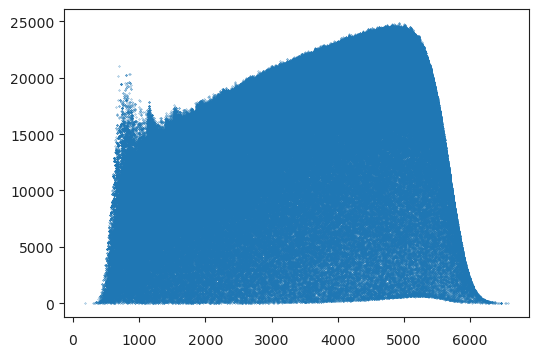

In [45]:
fig, axs = fig_setup(1, 1)
axs[0].plot(
    data[:,0], data[:,1],
    '.', ms=0.5
)

In [46]:
data

array([[ 1654.977027,  3470.      ],
       [ 1840.67676 ,   371.      ],
       [  876.52216 ,  3329.      ],
       ...,
       [ 4903.432491, 22213.      ],
       [ 4537.244142, 21768.      ],
       [ 5614.715049,  9140.      ]])

In [26]:
result[0].result[:10]
x[:3,1]

[('STVQIVNNGKILKLF', 1654.9770269999997),
 ('GPDMDELSGDSNFTMED', 1840.67676),
 ('TVRFFIL', 876.52216),
 ('PSMLLESEDELLVDEEEAAALLESGSSVGDETDLANL', 3871.7932350000005),
 ('PIDLMKIQQKLKMEEYD', 2103.074427),
 ('AILSFLHIWAV', 1250.717565),
 ('GKCMSQTNSTFTFTTCRILHPSD', 2556.1559519999996),
 ('SGKPATTSAQLPLEPPLWRLQRHEEGSETAVEGGQ', 3737.876154),
 ('PVNIKAARQDLLAVPPDLTSAAAMYRGPVYALHDVS', 3801.0035850000004),
 ('GFSEPYLQFQDPSKHSRKVNPTTKYLVISLSVLS', 3847.0308430000005)]

array(['1654.9770269999997', '1840.67676', '876.52216'], dtype='<U50')

## Within so many PPM

In [ ]:
# Constants
# mass = 1000
# ppm_tol = 10
masses = np.arange(50, 7201, 2)
# masses = # masses in the kmer database
ppm_tols = [3, 5, 10, 20]
# ppm_tols = [10]

# Loop over PPM tolerances
data = []
for ppm_tol in ppm_tols:
    print(f"PPM tol = {ppm_tol}")
    # Generate queries to look for masses that explain given mass
    queries = []
    for mass in masses:
        da_tol = relative_ppm_tolerance_in_daltons(ppm=ppm_tol, ref_mass=mass)
        # print(f"Dalton tolerance for mass={mass} is {da_tol}")
        queries.append(
            get_query_to_select_rows_by_mass(mass=mass, mass_tol=da_tol)
    )

    # Execute all the queries in parallel
    t0 = time.time()
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(lambda query: query_database(query=query, db_path=KMERS_DB_PATH)[0][0], queries))
    t1 = time.time()
    print(f"\tTook {round(t1-t0, 2)} seconds for {len(queries)} queries")

    # Add results to growing array of data
    data.extend(
        [(ppm_tol, masses[ii], results[ii]) for ii in range(len(results))]
    )
# queries

PPM tol = 3
	Took 0.47 seconds for 3576 queries
PPM tol = 5
	Took 0.37 seconds for 3576 queries
PPM tol = 10
	Took 0.46 seconds for 3576 queries
PPM tol = 20
	Took 0.56 seconds for 3576 queries


In [ ]:
PT, M, NEM = "ppm_tol", "mass", "num_explaining_masses"
data = pd.DataFrame(data, columns=[PT, M, NEM])

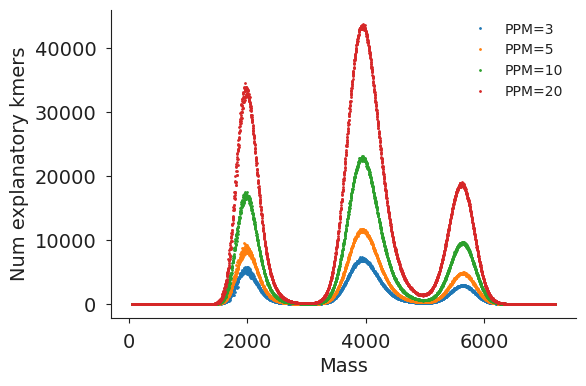

In [ ]:
_, axs = fig_setup(1, 1)
for ppm_tol in ppm_tols:
    _=axs[0].plot(
        data[data[PT]==ppm_tol][M], data[data[PT]==ppm_tol][NEM],
        'o', ms=1, label=f"PPM={ppm_tol}"
    )
set_title_axes_labels(axs[0], ylabel="Num explanatory kmers", xlabel="Mass")
# axs[0].set_ylim(top=50, bottom=0)
# axs[0].set_xlim(right=1500, left=0)
finalize(axs)

In [ ]:
1123.344121351235213351235

1122 +- 0.005

In [ ]:
relative_ppm_tolerance_in_daltons(ppm=5, ref_mass=100)

0.0005

## Within so many Daltons

In [ ]:
# Constants
# mass = 1000
# ppm_tol = 10
masses = np.arange(50, 7201, 2)
da_tols = [1, 3, 5, 10]
# da_tols = [10]

# Loop over PPM tolerances
data = []
for da_tol in da_tols:
    print(f"Dalton tolerance = {da_tol}")
    # Generate queries to look for masses that explain given mass
    queries = []
    for mass in masses:
        # print(f"Dalton tolerance for mass={mass} is {da_tol}")
        queries.append(
            get_query_to_select_rows_by_mass(mass=mass, mass_tol=da_tol)
    )

    # Execute all the queries in parallel
    t0 = time.time()
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(lambda query: query_database(query=query, db_path=KMERS_DB_PATH)[0][0], queries))
    t1 = time.time()
    print(f"\tTook {round(t1-t0, 2)} seconds for {len(queries)} queries")

    # Add results to growing array of data
    data.extend(
        [(da_tol, masses[ii], results[ii]) for ii in range(len(results))]
    )
# queries

Dalton tolerance = 1
	Took 2.56 seconds for 3576 queries
Dalton tolerance = 3
	Took 6.01 seconds for 3576 queries
Dalton tolerance = 5
	Took 9.04 seconds for 3576 queries
Dalton tolerance = 10
	Took 18.22 seconds for 3576 queries


In [ ]:
DT, M, NEM = "da_tol", "mass", "num_explaining_masses"
data = pd.DataFrame(data, columns=[DT, M, NEM])

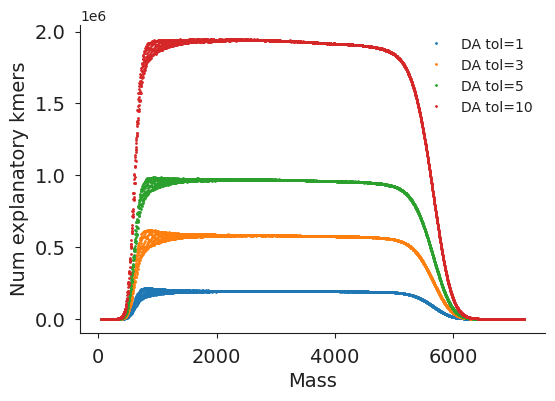

In [ ]:
_, axs = fig_setup(1, 1)
for da_tol in da_tols:
    _=axs[0].plot(
        data[data[DT]==da_tol][M], data[data[DT]==da_tol][NEM],
        'o', ms=1, label=f"DA tol={da_tol}"
    )
set_title_axes_labels(axs[0], ylabel="Num explanatory kmers", xlabel="Mass")
finalize(axs)

In [4]:
from dataclasses import dataclass
@dataclass
class A:
    mass: float
    seq: str

# List representing an instance of class A
x = [1.0, "abc"]

# Create an instance of A using unpacking
a = A(*x)
a

A(mass=1.0, seq='abc')

In [ ]:
a